# Generate DET Curves specific to the different subgroups of the Balance Faces in the Wild (BFW) dataset.

Uses the data in `data/bfw-datatable.pkl` to evaluate DET curves of different attributes.

In [1]:
import pathlib
path_package=f'../'
import sys
if path_package not in sys.path:
    sys.path.append(path_package)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as mtick

import seaborn as sns

sns.set(font_scale=1.1)
# Load out custom tool for loading and processing the data
from facebias.io import load_bfw_datatable
from facebias.visualization import draw_det_curve
from facebias.metrics import calculate_det_curves

## Setings for notebook run
set values per preferences for current session

In [13]:
fontsize=12

# plotting
sns.set_style("whitegrid")
sns.set_context("paper", rc={"font.size": fontsize, "axes.titlesize": fontsize, "axes.labelsize": fontsize})

# parameters and filepaths
ticks_to_use_x=(1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e-0)

# datatable (See Load Data)
f_datatable = '../../data/bfw-v0.1.5-datatable.pkl'

dir_out = '../../results/sdm/baseline/'
dir_interm_out = '../../data/interm/sdm/'

save_plots = False # save plots to disc, in folder 'dir_out'
save_intermediate = False # save data to replot det curves without waiting for calculations
overwrite_existing = False # only save if files do not exist

opts = [{'color': 'g', 'alpha': 0.7, 'norm_hist': True}, {'color': 'r', 'alpha': 0.7, 'norm_hist': True}] # currently not used
if save_intermediate:
    pathlib.Path(dir_interm_out).mkdir(parents=True,exist_ok=True)
if save_plots:
    pathlib.Path(dir_out).mkdir(parents=True,exist_ok=True)

## Load the data

Read in the data as a pandas.DataFrame and display the first few rows.

More information and process to build datatable is exemplified in [0_prepare_datatable.ipynb](0_prepare_datatable.ipynb).

Scores for pairs are assumed to be calculated and added as column of datatable. The process for adding this column is demonstrated in [1_compare_features.ipynb](1_compare_features.ipynb)

**Note** that the demo uses scores from setnet50, as it creates a column *score* with the respective values. Just set *score* column to any set of scores that are intended for analysis.

In [8]:
data = load_bfw_datatable(f_datatable)
data['score'] = data['senet50']
data.head()

,fold,p1,p2,label,id1,id2,att1,att2,vgg16,resnet50,senet50,a1,a2,g1,g2,e1,e2,score
0,1,asian_females/n000009/0010_01.jpg,asian_females/n000009/0043_01.jpg,1,0,0,asian_females,asian_females,0.820039,0.703258,0.679089,AF,AF,F,F,A,A,0.679089
1,1,asian_females/n000009/0010_01.jpg,asian_females/n000009/0120_01.jpg,1,0,0,asian_females,asian_females,0.719199,0.523613,0.594268,AF,AF,F,F,A,A,0.594268
2,1,asian_females/n000009/0010_01.jpg,asian_females/n000009/0122_02.jpg,1,0,0,asian_females,asian_females,0.732029,0.527567,0.643680,AF,AF,F,F,A,A,0.643680
3,1,asian_females/n000009/0010_01.jpg,asian_females/n000009/0188_01.jpg,1,0,0,asian_females,asian_females,0.607093,0.348211,0.458883,AF,AF,F,F,A,A,0.458883
4,1,asian_females/n000009/0010_01.jpg,asian_females/n000009/0205_01.jpg,1,0,0,asian_females,asian_females,0.629153,0.384273,0.494913,AF,AF,F,F,A,A,0.494913


In [6]:
classes_abbreviated = np.unique(list(np.unique(data.a1)) + list(np.unique(data.a2)))
classes_abbreviated.sort()

print(f"there are {len(classes_abbreviated)} types: {classes_abbreviated}")

there are 8 types: ['AF' 'AM' 'BF' 'BM' 'IF' 'IM' 'WF' 'WM']


In [9]:
subgroups = data.groupby('a1')
li_subgroups = subgroups.groups

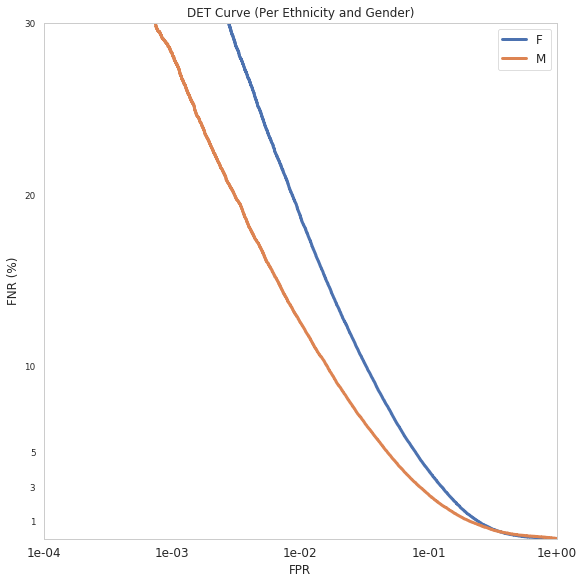

In [19]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, :])
for i, subgroup in enumerate(li_subgroups):
    # for each subgroup
    fout = f"{dir_out}/det_data_{subgroup}.pkl"
    if pathlib.Path(fout).is_file() and not overwrite_existing:
        det_data = pd.read_pickle(fout)
        fpr, fnr, thresholds = det_data['fpr'], det_data['fnr'], det_data['thresholds']
    else:
        df_subgroup = subgroups.get_group(subgroup)
        labels, scores = df_subgroup['label'].values.astype(int), df_subgroup['score'].values
        fpr, fnr, thresholds = calculate_det_curves(labels, scores)
        if save_intermediate:
            pd.to_pickle({'fpr': fpr, 'fnr': fnr, 'thresholds': thresholds}, fout)
    ax1 = draw_det_curve(fpr, fnr, ax=ax1, label=subgroup, fontsize=fontsize,title='DET Curve (Per Ethnicity and Gender)')

ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
plt.minorticks_off()
ax1.set_ylabel('FNR (%)',fontsize=fontsize)
ax1.set_xlabel('FPR', fontsize=fontsize)
plt.legend(fontsize=fontsize)
ax1.set_xlim([1e-4, 1])
ax1.set_ylim([0, 30])

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
plt.grid(False)
if save_plots and overwrite_existing:
    plt.savefig(f"{dir_out}/curve_subgroups.pdf")
    plt.savefig(f"{dir_out}/curve_subgroups.png")

In [20]:
subgroups = data.groupby('g1')
li_subgroups = subgroups.groups
classes_abbreviated=list(li_subgroups.keys())
print(f"there are {len(classes_abbreviated)} types: {classes_abbreviated}")

there are 2 types: ['F', 'M']


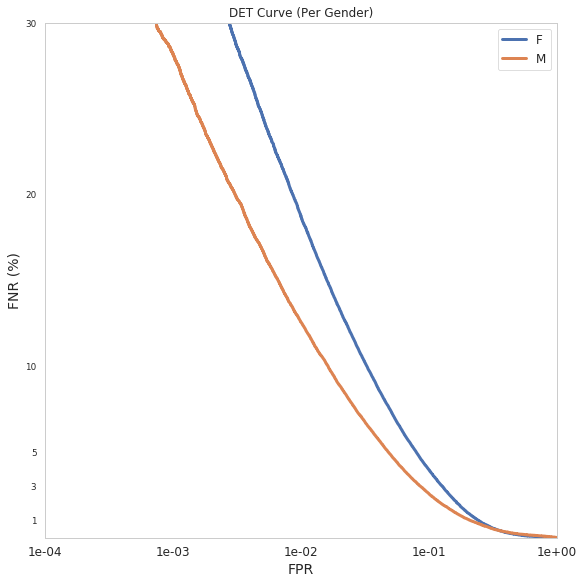

In [22]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, :])
for i, subgroup in enumerate(li_subgroups):
    # for each subgroup
    fout = f"{dir_out}/det_data_{subgroup}.pkl"
    if pathlib.Path(fout).is_file() and not overwrite_existing:
        det_data = pd.read_pickle(fout)
        fpr, fnr, thresholds = det_data['fpr'], det_data['fnr'], det_data['thresholds']
    else:
        df_subgroup = subgroups.get_group(subgroup)
        labels, scores = df_subgroup['label'].values.astype(int), df_subgroup['score'].values
        fpr, fnr, thresholds = calculate_det_curves(labels, scores)
        if save_intermediate:
            pd.to_pickle({'fpr': fpr, 'fnr': fnr, 'thresholds': thresholds}, fout)
    ax1 = draw_det_curve(fpr, fnr, ax=ax1, label=subgroup, fontsize=fontsize, title='DET Curve (Per Gender)')

ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
plt.minorticks_off()
ax1.set_ylabel('FNR (%)',fontsize=fontsize+2)
ax1.set_xlabel('FPR', fontsize=fontsize+2)
plt.legend(fontsize=fontsize)
ax1.set_xlim([1e-4, 1])
ax1.set_ylim([0, 30])
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
plt.grid(False)
if save_plots and overwrite_existing:
    
    plt.savefig(f"{dir_out}/curve_genders.pdf")
    plt.savefig(f"{dir_out}/curve_genders.png")

In [23]:
subgroups = data.groupby('e1')
li_subgroups = subgroups.groups
classes_abbreviated=list(li_subgroups.keys())
print(f"there are {len(classes_abbreviated)} types: {classes_abbreviated}")

there are 4 types: ['A', 'B', 'I', 'W']


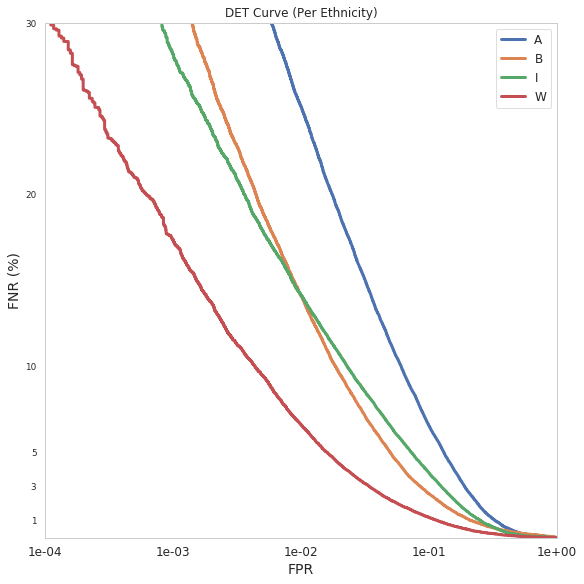

In [24]:
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, :])
for i, subgroup in enumerate(li_subgroups):
    # for each subgroup
    fout = f"{dir_out}/det_data_{subgroup}.pkl"
    if pathlib.Path(fout).is_file() and not overwrite_existing:
        det_data = pd.read_pickle(fout)
        fpr, fnr, thresholds = det_data['fpr'], det_data['fnr'], det_data['thresholds']
    else:
        df_subgroup = subgroups.get_group(subgroup)
        labels, scores = df_subgroup['label'].values.astype(int), df_subgroup['score'].values
        fpr, fnr, thresholds = calculate_det_curves(labels, scores)
        if save_intermediate:
            pd.to_pickle({'fpr': fpr, 'fnr': fnr, 'thresholds': thresholds}, fout)
    ax1 = draw_det_curve(fpr, fnr, ax=ax1, label=subgroup, fontsize=fontsize, title='DET Curve (Per Ethnicity)')

ax1.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.e'))
plt.minorticks_off()
ax1.set_ylabel('FNR (%)',fontsize=fontsize+2)
ax1.set_xlabel('FPR', fontsize=fontsize+2)
plt.legend(fontsize=fontsize)
ax1.set_xlim([1e-4, 1])
ax1.set_ylim([0, 30])
for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
plt.grid(False)
if save_plots and overwrite_existing:
    plt.savefig(f"{dir_out}/curve_ethnicity.pdf")
    plt.savefig(f"{dir_out}/curve_ethnicity.png")